In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf

import MathOptInterface as MOI
import Ipopt 
using Statistics 

  Activating environment at `C:\Users\shara\OCRL_Project\Project.toml`


In [2]:
include(joinpath(@__DIR__, "utils","mpc_visualizer.jl"))
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

In [3]:
function car_dynamics(x::Vector, u::Vector)::Vector
    # nonlinear bicycle model continuous time dynamics 
    px, py, θ, δ, v = x 
    a, δdot = u 
    L = 2.8
    lr = 1.6
    
    β = atan(lr * δ, L)
    s,c = sincos(θ + β)
    sb=sin(β)
    ω = v*cos(β)*tan(δ) / L
    
    vx = v*c 
    vy = v*s 
    vs=v*sb/lr
   
    

    xdot = [
        vx,
        vy,
        ω,
        δdot, 
        a
    ]
end
function rk4( ode::Function, x, u, dt::Real)
    k1 = dt * ode(x, u)
    k2 = dt * ode( x + k1/2, u)
    k3 = dt * ode( x + k2/2, u)
    k4 = dt * ode( x + k3,   u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end   


rk4 (generic function with 1 method)

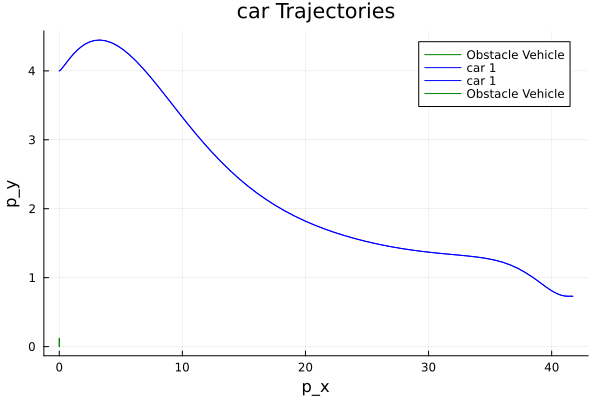

In [17]:

function obs_controller(N)
    dt = 0.2  
    K = 0.03 
    x_ic=[0,0,0,0,0]
    x_goal=[20,0,0,0,0]
    X=[zeros(5) for i = 1:N]
    X[1]=x_ic
    for k in 1:N-1 
        u = -K * (X[k] - x_goal) 
        X[k+1] = rk4(car_dynamics, X[k], u, dt) 
        
    end
    return X
end

x2ic = [0,0,0,0,0]
x2g = [20,0,0,0,0] 
dt = 0.2
tf = 15.0 
t_vec = 0:dt:tf 
N = length(t_vec)
X2=obs_controller(N)
display(plot!(X2[1,:], X2[2,:], color = :green, label = "Obstacle Vehicle", xlabel = "p_x", ylabel = "p_y"))




In [26]:
function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end


function cvx_update(Xsim::Vector{Vector{Float64}}, 
                    As::Vector{Matrix{Float64}},  
                    Bs::Vector{Matrix{Float64}},  
                    Q::Matrix,                    
                    R::Matrix,                   
                    Qf::Matrix                     
                    )::Vector{Vector{Float64}}     
    N = length(Xsim)
    nx,nu = size(Bs[1])
    
    X = cvx.Variable(nx, N)
    U = cvx.Variable(nu, N-1)
    
    x2ic = [0,0,0,0,0]
    x2g = [20,0,0,0,0] 
    xic=[0,5,0,0,0]
    u_max=ones(2)
    u_min=-u_max
    dt = 0.2
    tf = 15.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)

    X2=obs_controller(N)
    X2=hcat(X2...)

    xg= [43, 2.2, 0, 0, 0]
    cost = 0.0
    for k = 1:(N-10)
        x_k = X[:,k]
        u_k = U[:,k]
        xgg=X2[:,k+10]

        
        cost += 0.5*(cvx.quadform(x_k - xgg, Q)) + 0.5*(cvx.quadform(u_k, R))
    end
    
    # terminal cost
    x_n = X[:,end]
    cost += (cvx.quadform(x_n - xg, Qf))
    
    # problem instance 
    prob = cvx.minimize(cost)

    # TODO: initial condition constraint
    prob.constraints += (X[:,1] == xic)
    prob.constraints += (X[:,N] == xg)
    
    
    for k = 1:N-1
        x3= X[3,k]
        x4=X[4,k]
        #steering and angular constraints
        prob.constraints += x3 >= 0
        prob.constraints += x3 <= 20
        prob.constraints += x4 >= 0
        prob.constraints += x4 <= 20
        
        
        
    end
    
    for k = 1:N
        xi1 = X[:,k][1:2]
        lat_val = X[:,k][2]
        
        xi2 = [X2[1,k],X2[2,k]]
        # vel= X2[5,k]
        prob.constraints += norm(xi1-xi2) >=6 #obstacle avoidance
        
        prob.constraints += lat_val>=-2.5 #lane constraint
    
    end
    for k=1:N-15
        lat_val = X[:,k][2]
        prob.constraints += lat_val<=8 #lane constraint
    end
    for k=1:N-1
        vel_ego = X[:,k][5]
        vel_obs= X2[5,k]
        prob.constraints += vel_ego > vel_obs #velocity constraint
    end
    for k=1:N-1
        prob.constraints += U[:,k] >= u_min
        prob.constraints += U[:,k] <= u_max
        
    end
    
    

    #dynamics constraints
    for k = 1:(N-1)
        prob.constraints += (X[:,k+1] == As[k]*X[:,k] + Bs[k]*U[:,k])
    end

    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # return ΔU 
    x=X.value
    u=U.value
    X = vec_from_mat(x)
    U = vec_from_mat(u)

    return U
end

cvx_update (generic function with 2 methods)

In [27]:
function finetune(xi, xg, u)
    return u
    
end

finetune (generic function with 1 method)

┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\dcp.jl:25
┌ Warning: Problem not DCP compliant: constraint 303 is not DCP
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\problems.jl:60
┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\dcp.jl:25
┌ Warning: Problem not DCP compliant: constraint 305 is not DCP
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\problems.jl:60
┌ Warning: Expression not DCP compliant. Trying to solve non-DCP compliant problems can lead to unexpected behavior.
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\dcp.jl:25
┌ Warning: Problem not DCP compliant: constraint 307 is not DCP
└ @ Convex C:\Users\shara\.julia\packages\Convex\b2S4H\src\problems.jl:60
┌ Warning: Expression not DC

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj2" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s18" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p43" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x70, 0x34, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s53" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x35, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s19" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x31, 0x39], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p60" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x70, 0x36, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p74" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x32, 0x2f, 0x70, 0x37, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "traj3" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("s23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x33, 0x2f, 0x73, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x74, 0x72, 0x61, 0x6a, 0x33, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s18" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa

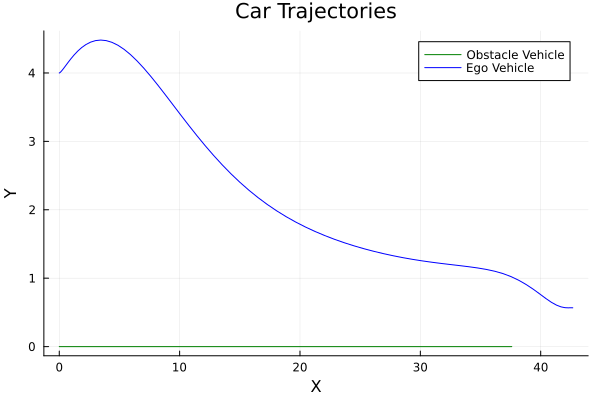

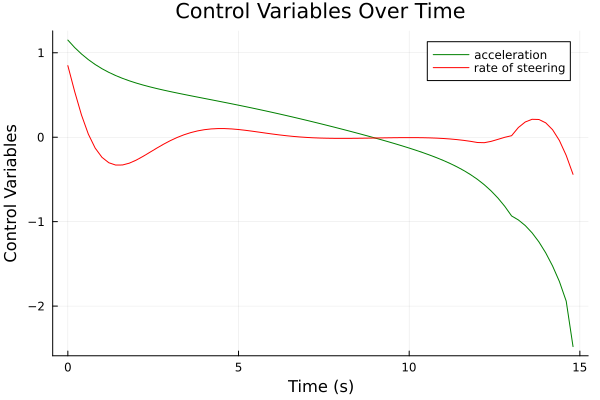

Test Summary: |
CVX           | No tests

Test.DefaultTestSet("CVX", Any[], 0, false, false)

In [28]:
@testset "CVX" begin 
    
    nx = 5
    nu = 2
    dt = 0.2
    tf = 15.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    xic=[0,4,0,0,0]
    xg= [43, 2.2, 0, 0, 0]
    x2ic=[0,0,0,0,0]
    x2g=[20,0,0,0,0]
    
    X2=obs_controller(N)
    Q = diagm([5,5,5,5,10])
    R = 1*diagm(ones(nu))
    Qf = 1*diagm(ones(nx))
  

    Xsim = [zeros(nx) for i = 1:N]
    Xsim[1] = xic
    
    As = [zeros(nx,nx) for i = 1:N]
    Bs = [zeros(nu,nx) for i = 1:N-1]
    ug=[0,0]

    #lanes
    l1_1=[zeros(5) for i = 1:N]
    l1_2=[zeros(5) for i = 1:N]
    l2_1=[zeros(5) for i = 1:N]

    for i in 1:N
        l1_1[i]=[i,-2.5,0,0,0]
        l1_2[i]=[i,2.5,0,0,0]
        l2_1[i]=[i,7.5,0,0,0]
    end
            
    for i = 1:(N-1)
        xgg=X2[i]
        
        As[i] = FD.jacobian(x -> rk4(car_dynamics, x, ug, dt), xgg)
        Bs[i] = FD.jacobian(u -> rk4(car_dynamics, xgg, u, dt), ug)
    end 


    for ilc_iter = 1:10 # it should not take more than 10 iterations to converge 
        U = cvx_update(Xsim,As, Bs, Q, R, Qf)
        # U_n=finetune_model(Xsim[i],xg,U)
        for i = 1:(N-1)
            U_n=finetune(Xsim[i],xg,U[i])
            Xsim[i+1] = rk4(car_dynamics, Xsim[i], U_n, dt)
        end
    end
    U = cvx_update(Xsim,As, Bs, Q, R, Qf)
    #U=hcat(U...)
    U1 = [u[1] for u in U]  
    U2 = [u[2] for u in U] 
    t_control = t_vec[1:end-1]
        
    
    # --------plotting/animation-------
    Xm= hcat(Xsim...)
    X2m=hcat(X2...)

    # # animation
    vis = Visualizer()
    #lanes
    vis_traj!(vis, :traj1, [[x[1],x[2],0.1] for x in l1_1]; R = 0.02)
    vis_traj!(vis, :traj2, [[x[1],x[2],0.1] for x in l1_2]; R = 0.02)
    vis_traj!(vis, :traj3, [[x[1],x[2],0.1] for x in l2_1]; R = 0.02)
    
    build_car2!(vis[:car])
    build_car!(vis[:car2])
    anim = mc.Animation(floor(Int,1/dt))
    for k = 1:N
        mc.atframe(anim, k) do
            update_car_pose!(vis[:car2], Xsim[k])
            update_car_pose!(vis[:car], X2[k])
        end
    end
    mc.setanimation!(vis, anim)
    display(render(vis))
    plot(X2m[1,:], X2m[2,:], color = :green, xlabel="X", ylabel="Y",title = "Car Trajectories", label = "Obstacle Vehicle")
    display(plot!(Xm[1,:], Xm[2,:], color = :blue,title = "Car Trajectories", label = "Ego Vehicle"))
    plot(t_control, U1,color=:green, label="acceleration", xlabel="Time (s)", ylabel="Control Variables", title="Control Variables Over Time")
    display(plot!(t_control, U2, color=:red,label="rate of steering"))
        
end